In [23]:
import os
import sys
sys.path.append(os.getcwd())
from IPython.display import display
import torch
from torch import nn
import numpy as np
import pandas as pd 
import  altair as alt
import model
from model import Build_Transformer,Transformer 
import config
from config import get_weights_file_path,get_config,latest_weights_file_path
import train
from train import get_model,get_ds,greedy_decode,run_validation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [24]:
device="cuda" if torch.cuda.is_available() else "cpu"
    # device='cpu'
print(f'using device {device}')


using device cuda


In [25]:
config = get_config()
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = latest_weights_file_path(config)
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

Max length of src sentance:309
Max length of tgt sentance:274


<All keys matched successfully>

In [4]:
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: print(msg), 0, None, num_examples=10)

--------------------------------------------------------------------------------
SOURCE:CHAPTER XIII
TARGET:XIII
PREDICTED:XIII
--------------------------------------------------------------------------------
SOURCE:I then made signs to them for some water, and held out one of my jars to them, turning it bottom upward, to show that it was empty, and that I wanted to have it filled.
TARGET:In appresso i miei segni furono intesi ad avere una certa quantità di acqua dolce, e mi feci capire voltando uno de’ miei otri con la bocca all’ingiù, affinchè vedessero che aveva bisogno di essere empiuto.
PREDICTED:In appresso feci loro qualche parte per qualche secondo di essi , e lo feci cadere , nella mia o , affinchè per alcun valore , bisognava riuscire che per esserne l ’ uopo che avrei voluto .
--------------------------------------------------------------------------------
SOURCE:Forgive me!
TARGET:— Oh! zia, abbiate pietà di me!
PREDICTED:Scusatemi , vi lascio un momento .
-----------------

In [26]:
config = get_config()
train_dataloader, val_dataloader, vocab_src, vocab_tgt = get_ds(config)
model = get_model(config, vocab_src.get_vocab_size(), vocab_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"19")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])



Max length of src sentance:309
Max length of tgt sentance:274


<All keys matched successfully>

In [27]:
def load_next_batch():
    # Load a sample batch from the validation set
    batch = next(iter(val_dataloader))
    encoder_input = batch["encoder_input"].to(device)
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_input = batch["decoder_input"].to(device)
    decoder_mask = batch["decoder_mask"].to(device)

    encoder_input_tokens = [vocab_src.id_to_token(idx) for idx in encoder_input[0].cpu().numpy()]
    decoder_input_tokens = [vocab_tgt.id_to_token(idx) for idx in decoder_input[0].cpu().numpy()]

    # check that the batch size is 1
    assert encoder_input.size(
        0) == 1, "Batch size must be 1 for validation"

    model_out = greedy_decode(
        model, encoder_input, encoder_mask, vocab_src, vocab_tgt, config['seq_len'], device)
    
    return batch, encoder_input_tokens, decoder_input_tokens
    

In [ ]:
# def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
#     return pd.DataFrame(
#         [
#             (
#                 r,
#                 c,
#                 float(m[r, c]),
#                 "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
#                 "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
#             )
#             for r in range(m.shape[0])
#             for c in range(m.shape[1])
#             if r < max_row and c < max_col
#         ],
#         columns=["row", "column", "value", "row_token", "col_token"],
#     )

# def get_attn_map(attn_type: str, layer: int, head: int):
#     if attn_type == "encoder":
#         attn = model.encoder.layers[layer].self_multihead_attention.attention_scores
#     elif attn_type == "decoder":
#         attn = model.decoder.layers[layer].self_multihead_attention.attention_scores
#     elif attn_type == "encoder-decoder":
#         attn = model.decoder.layers[layer].cross_multihead_attention.attention_scores
#     return attn[0, head].data

# def attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len):
#     df = mtx2df(
#         get_attn_map(attn_type, layer, head),
#         max_sentence_len,
#         max_sentence_len,
#         row_tokens,
#         col_tokens,
#     )
#     return (
#         alt.Chart(data=df)
#         .mark_rect()
#         .encode(
#             x=alt.X("col_token", axis=alt.Axis(title="")),
#             y=alt.Y("row_token", axis=alt.Axis(title="")),
#             color="value",
#             tooltip=["row", "column", "value", "row_token", "col_token"],
#         )
#         #.title(f"Layer {layer} Head {head}")
#         .properties(height=400, width=400, title=f"Layer {layer} Head {head}")
#         .interactive()
#     )

# def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], row_tokens: list, col_tokens, max_sentence_len: int):
#     charts = []
#     for layer in layers:
#         rowCharts = []
#         for head in heads:
#             rowCharts.append(attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len))
#         charts.append(alt.hconcat(*rowCharts))
#     return alt.vconcat(*charts)
    

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_attn_map(attn_type: str, layer: int, head: int):
    # Same as original
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_multihead_attention.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_multihead_attention.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_multihead_attention.attention_scores
    return attn[0, head].data.cpu().numpy()  # Convert to numpy array

def plot_attention(ax, matrix, row_tokens, col_tokens, max_len, layer, head):
    # Trim to max sentence length
    matrix = matrix[:max_len, :max_len]
    
    # Plot heatmap
    im = ax.imshow(matrix, cmap='viridis', aspect='auto')
    
    # Set labels
    ax.set_title(f"L{layer} H{head}", fontsize=10)
    ax.set_xticks(np.arange(len(col_tokens[:max_len])))
    ax.set_yticks(np.arange(len(row_tokens[:max_len])))
    
    # Format labels with token indices and text
    x_labels = [f"{i:03d} {t}" if i < len(col_tokens) else "<blank>" 
                for i, t in enumerate(col_tokens[:max_len])]
    y_labels = [f"{i:03d} {t}" if i < len(row_tokens) else "<blank>" 
                for i, t in enumerate(row_tokens[:max_len])]
    
    ax.set_xticklabels(x_labels, rotation=90, fontsize=6)
    ax.set_yticklabels(y_labels, fontsize=6)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.7)

def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], 
                          row_tokens: list, col_tokens: list, max_sentence_len: int):
    n_layers = len(layers)
    n_heads = len(heads)
    
    # Create subplot grid
    fig, axs = plt.subplots(n_layers, n_heads, figsize=(4*n_heads, 4*n_layers))
    
    # Handle single layer/head case
    if n_layers == 1 and n_heads == 1:
        axs = np.array([[axs]])
    elif n_layers == 1 or n_heads == 1:
        axs = axs.reshape(n_layers, n_heads)
        
    # Plot each attention head
    for layer_idx, layer in enumerate(layers):
        for head_idx, head in enumerate(heads):
            ax = axs[layer_idx, head_idx]
            attn_matrix = get_attn_map(attn_type, layer, head)
            plot_attention(
                ax=ax,
                matrix=attn_matrix,
                row_tokens=row_tokens,
                col_tokens=col_tokens,
                max_len=max_sentence_len,
                layer=layer,
                head=head
            )
    
    plt.tight_layout()
    return fig

In [29]:
batch, encoder_input_tokens, decoder_input_tokens = load_next_batch()
print(f'Source: {batch["src_text"][0]}')
print(f'Target: {batch["tgt_text"][0]}')
sentence_len = encoder_input_tokens.index("[PAD]")

Source: Masha promised to write to Constantine in case of need, and to try to persuade Nicholas to go and live with him.
Target: Maša promise di scrivere a Konstantin in caso di necessità e di convincere Nikolaj Levin ad andare a vivere presso il fratello.


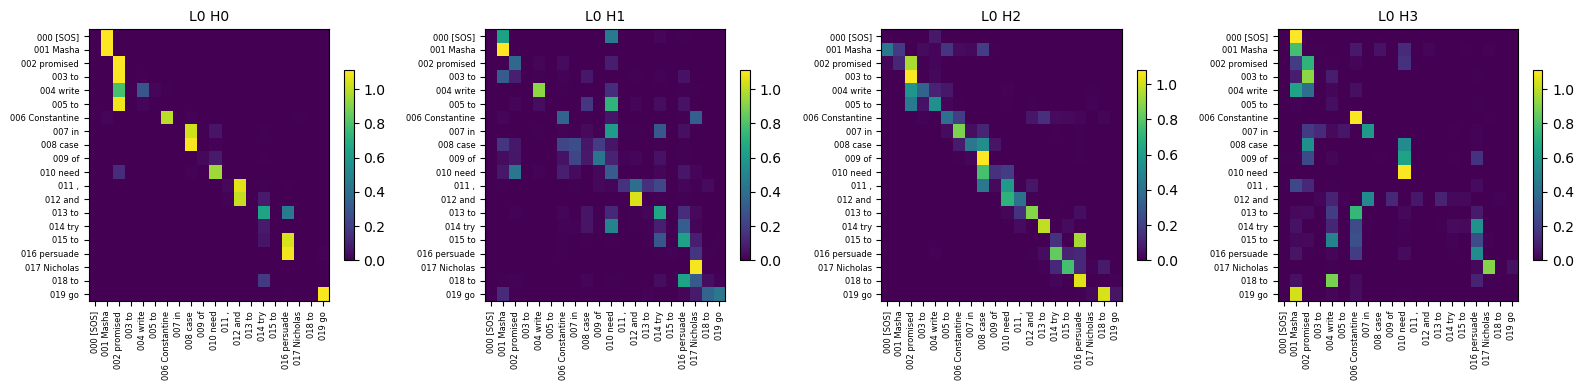

In [30]:
layers = [0]
heads = [0, 1, 2, 3]

# Encoder Self-Attention
chart=get_all_attention_maps("encoder", layers, heads, encoder_input_tokens, encoder_input_tokens, min(20, sentence_len))
# plt.figure(figsize=(150,150))
chart.show()


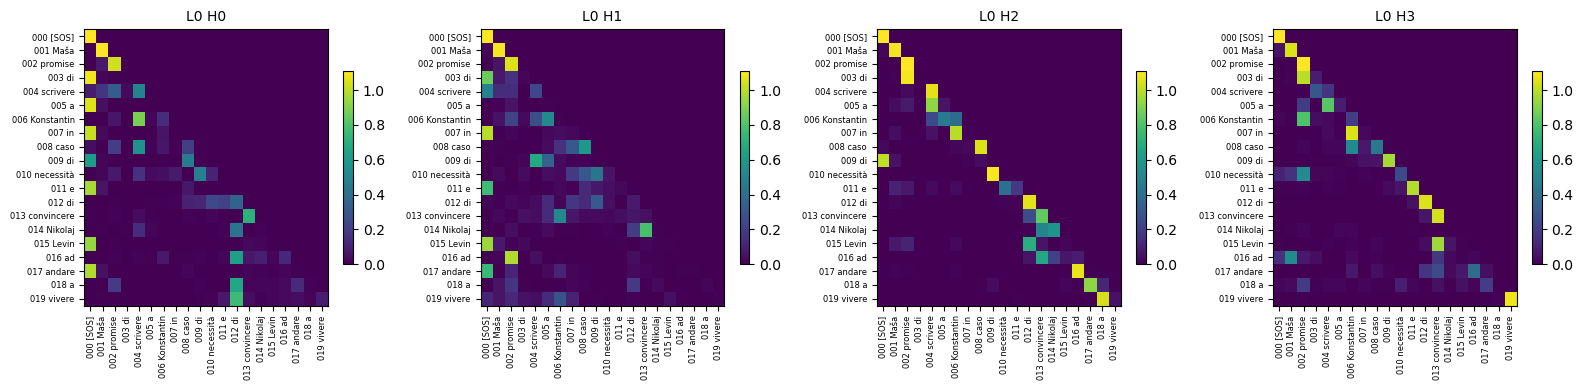

In [31]:
# Encoder Self-Attention
chart=get_all_attention_maps("decoder", layers, heads, decoder_input_tokens, decoder_input_tokens, min(20, sentence_len))
chart.show()

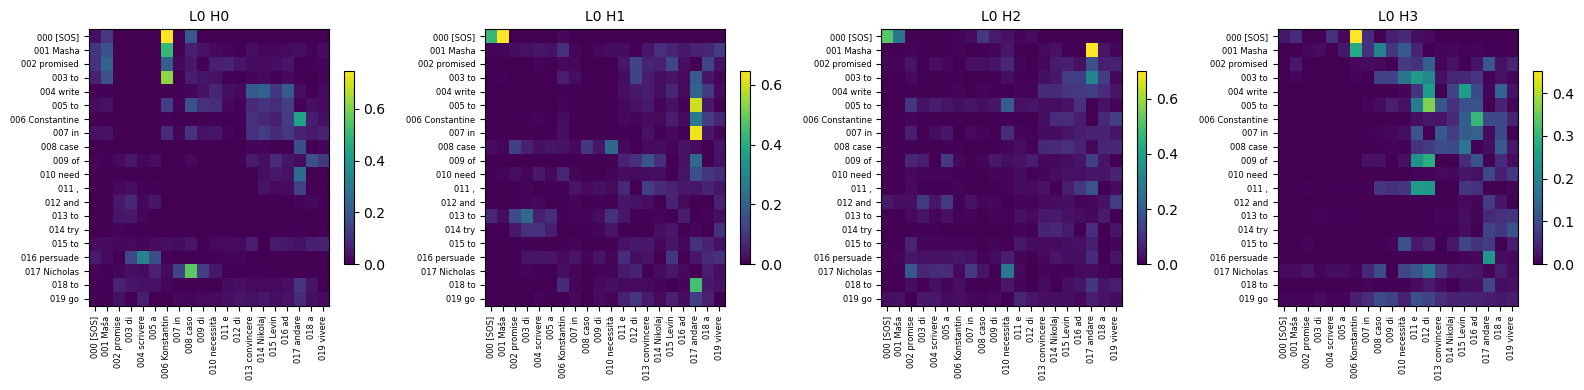

In [32]:
# Encoder Self-Attention
chart=get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))
chart.show()

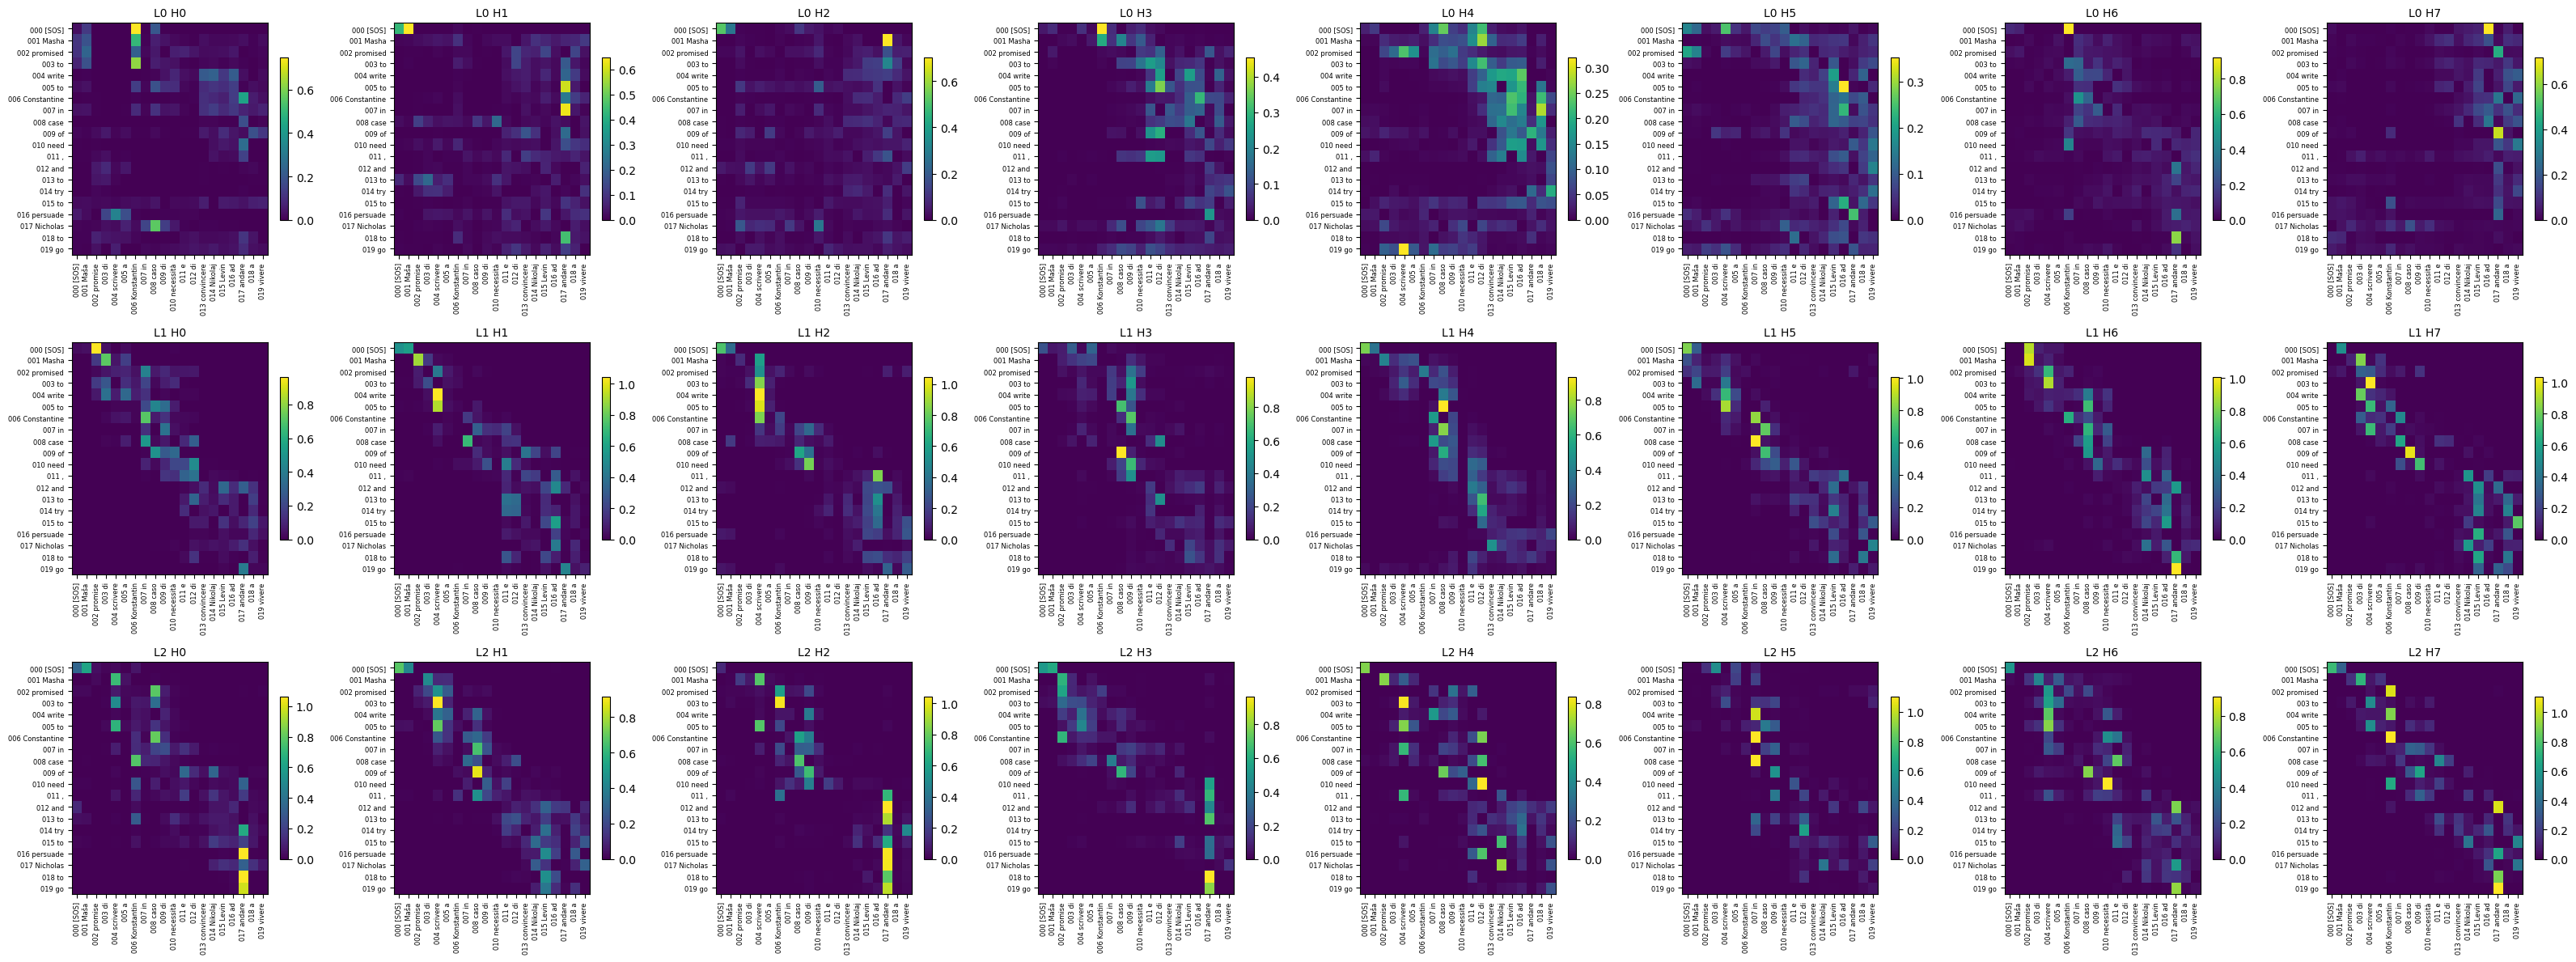

In [33]:
layers = [0,1,2]
heads = [0, 1, 2, 3,4,5,6,7]

chart=get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))
chart.show()